# OCP7 - Réalisez une analyse de sentiments grâce au Deep Learning
# Notebook 1 - Comparaison d'approches pour une classification de tweets

# Préparation

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

%load_ext autotime


time: 0 ns (started: 2024-02-03 09:36:36 +01:00)


Ce notebook utilise les versions des librairies suivantes :

- numpy == 1.18.5 

- pandas == 1.1.3

- tensorflow ==1.7.0

- keras == 2.4.3

- nltk ==3.5

- seaborn ==0.11.0

## Lecture des données

In [2]:
data = pd.read_csv("data_raw/eda-twitter-sentiment-analysis-using-nn.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

time: 9.53 s (started: 2024-02-03 09:36:36 +01:00)


## Analyse exploratoire des données

### 5 premières lignes

In [3]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


time: 15 ms (started: 2024-02-03 09:36:45 +01:00)


### 5 dernières lignes

In [4]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


time: 16 ms (started: 2024-02-03 09:36:45 +01:00)


### Colonnes du tableau

In [5]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

time: 31 ms (started: 2024-02-03 09:36:45 +01:00)


### Nombre de tweets (nombre de lignes)

In [6]:
print('lengh of data is', len(data))

lengh of data is 1599999
time: 0 ns (started: 2024-02-03 09:36:45 +01:00)


### Nombre de lignes, nombre de colonnes :

In [7]:
data.shape

(1599999, 6)

time: 0 ns (started: 2024-02-03 09:36:45 +01:00)


### Data types et valeurs manquantes :

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
time: 953 ms (started: 2024-02-03 09:36:45 +01:00)


## Pré-traitement des données

### Sélection des colonnes texte et label

In [9]:
data=data[['text','label']]

time: 31 ms (started: 2024-02-03 09:36:46 +01:00)


### Remplacement du label '4' par '1'

In [10]:
data['label'][data['label']==4]=1

time: 0 ns (started: 2024-02-03 09:36:46 +01:00)


### Séparation des tweets positifs et négatifs

In [11]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

time: 47 ms (started: 2024-02-03 09:36:46 +01:00)


### Garder seulement 25% des données, afin de pouvoir faire tourner le programme rapidement dans un premier temps

In [12]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

time: 0 ns (started: 2024-02-03 09:36:46 +01:00)


### Fusion des deux tableaux pour faire un tableau avec 20 000 tweets positifs et 20 000 tweets négatifs

In [13]:
data = pd.concat([data_pos, data_neg])

time: 31 ms (started: 2024-02-03 09:36:46 +01:00)


### Remplacement des majuscules par des minuscules

In [14]:
data['text']=data['text'].str.lower()

time: 15 ms (started: 2024-02-03 09:36:46 +01:00)


In [15]:
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

time: 0 ns (started: 2024-02-03 09:36:46 +01:00)


### Retrait des stopwords anglais

In [16]:
stopwords_list = stopwords.words('english')

time: 0 ns (started: 2024-02-03 09:36:46 +01:00)


In [17]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

time: 0 ns (started: 2024-02-03 09:36:46 +01:00)


Retirons ces stop words (mots présents dans la liste du dessus)

In [18]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

time: 109 ms (started: 2024-02-03 09:36:47 +01:00)


### Retrait des ponctuations

In [19]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


In [20]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

time: 125 ms (started: 2024-02-03 09:36:47 +01:00)


### Retrait des caractères répétés

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


In [22]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

time: 234 ms (started: 2024-02-03 09:36:47 +01:00)


### Retrait des emails

In [23]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


In [24]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

time: 47 ms (started: 2024-02-03 09:36:47 +01:00)


### Retrait des URL

In [25]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


In [26]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

time: 94 ms (started: 2024-02-03 09:36:47 +01:00)


### Retrait des nombres

In [27]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


In [28]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

time: 62 ms (started: 2024-02-03 09:36:47 +01:00)


### Tokenization des tweets

In [29]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

time: 110 ms (started: 2024-02-03 09:36:47 +01:00)


In [30]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

time: 0 ns (started: 2024-02-03 09:36:47 +01:00)


### Stemmatisation

In [31]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

time: 5.45 s (started: 2024-02-03 09:36:48 +01:00)


In [32]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

time: 15 ms (started: 2024-02-03 09:36:53 +01:00)


### Lemmatisation

In [33]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

time: 2.27 s (started: 2024-02-03 09:36:53 +01:00)


In [34]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

time: 0 ns (started: 2024-02-03 09:36:55 +01:00)


# Modèle simple (régression logistique)

## Approches Bag of Words : CountVectorizer

### Implémentation

In [35]:
# Formating needed for Bow approach
data['text_string'] = data['text'].apply(lambda x: ' '.join(x))

# Define X and y
X = data['text_string']
y = data['label']

# Instanciate count_vectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)

# Fit and transform the data
X = vectorizer.fit_transform(data['text_string'])

# Separate training and test data (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)

# Make predictions from the test data
y_pred = log_reg.predict_proba(X_test)[:, 1]

time: 531 ms (started: 2024-02-03 09:36:55 +01:00)


### Evaluation de la performance

#### Aire sous la courbe ROC

In [36]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Display the rounded result
print(f" ROC AUC score : {round(roc_auc,2)}")

 ROC AUC score : 0.74
time: 0 ns (started: 2024-02-03 09:36:56 +01:00)


#### Matrice de confusion

Pour la comparaison, je fixe un seuil de prédiction à 0.5 : les tweets avec une probabilité supérieure à 0.5 sont prédits comme positifs, et les autres négatifs.

In [37]:
# Calculate predictions on the test data
y_pred = log_reg.predict(X_test)
y_pred = (y_pred > 0.5) 

time: 0 ns (started: 2024-02-03 09:36:56 +01:00)


Voici la matrice de confusion :



confusion matrix


[[3305 2704]
 [1255 4736]]




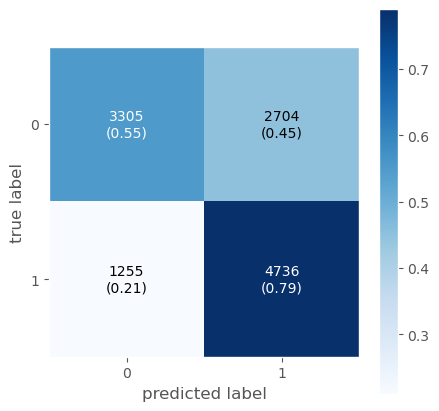

time: 203 ms (started: 2024-02-03 09:36:56 +01:00)


In [38]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## Approches Bag of Words : Tf-idf

### Implémentation

In [39]:
# Formating needed for Bow approach
data['text_string'] = data['text'].apply(lambda x: ' '.join(x))

# Define X and y
X = data['text_string']
y = data['label']

# Instanciate count_vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

# Fit and transform the data
X = vectorizer.fit_transform(data['text_string'])

# Separate training and test data (70% - 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)

# Make predictions from the test data
y_pred = log_reg.predict_proba(X_test)[:, 1]

time: 516 ms (started: 2024-02-03 09:36:56 +01:00)


### Evaluation de la performance

#### Aire sous la courbe ROC

In [40]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Display the rounded result
print(f" ROC AUC score : {round(roc_auc,2)}")

 ROC AUC score : 0.77
time: 0 ns (started: 2024-02-03 09:36:57 +01:00)


#### Matrice de confusion

Pour la comparaison, je fixe un seuil de prédiction à 0.5 : les tweets avec une probabilité supérieure à 0.5 sont prédits comme positifs, et les autres négatifs.

In [41]:
# Calculate predictions on the test data
y_pred = log_reg.predict(X_test) 
y_pred = (y_pred > 0.5) 

time: 0 ns (started: 2024-02-03 09:36:57 +01:00)


Voici la matrice de confusion :



confusion matrix


[[1293 4716]
 [ 190 5801]]




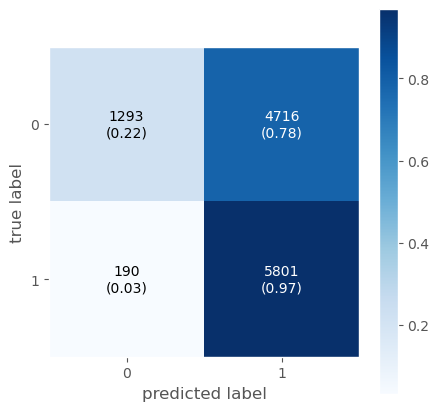

time: 156 ms (started: 2024-02-03 09:36:57 +01:00)


In [42]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Modèle avancé avec Tensorflow

## Modèle basique avec Embedding (Baseline)

###  Separation des features et des labels

In [71]:
X=data.text
y=data.label

time: 0 ns (started: 2024-02-03 09:51:37 +01:00)


### Encodage séquentiel des tokens
- conversion du texte en séquences numériques
- chaque tweet correspond à une séquence de 500 nombres
    - les tweet plus courts sont 'paddés' avec des 0 au début de la séquence
    - les tweet plus longs sont tronqués pour avoir seulement 500 nombres

In [72]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

time: 531 ms (started: 2024-02-03 09:51:37 +01:00)


J'ai donc 40 000 tweets, chaque tweet étant associé à 500 features.

Par exemple, pour la première ligne (premier tweet), la cinquième feature contient le nombre associé au mot correspondant, en cinquième position de la séquence (0 si le tweet a un nombre de tokens inférieur 495); et la dernière ligne contient le nombre associé au dernier mot du tweet.

In [73]:
sequences_matrix.shape

(40000, 500)

time: 15 ms (started: 2024-02-03 09:51:38 +01:00)


### Séparation des données entraînement-test (70-30)

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

time: 32 ms (started: 2024-02-03 09:51:38 +01:00)


### Compilation du modèle

In [75]:
def tensorflow_based_baseline_model():
    inputs = Input(name='inputs', shape=[max_len])  # step1: Define input layer
    layer = Embedding(2000, 50, input_length=max_len)(inputs)  # step2: Embedding layer
    layer = Flatten()(layer)  # New step3: Flatten the embeddings
    layer = Dense(256, name='FC1')(layer)  # step4: First dense layer
    layer = Activation('relu')(layer)  # step5: ReLU activation
    layer = Dropout(0.5)(layer)  # step6: Dropout for regularization
    layer = Dense(1, name='out_layer')(layer)  # Output layer for binary classification
    layer = Activation('sigmoid')(layer)  # Use sigmoid activation for binary output
    model = Model(inputs=inputs, outputs=layer)  # Finalize the model
    return model

time: 15 ms (started: 2024-02-03 09:51:38 +01:00)


- Etape 1 : l'input du modèle est constitué de 500 éléments, correspondant aux tokens encodés de façon séquentielle pour chaque tweet.

- Etape 2 : l'embedding permet de représenter les mots de manière à ce que les mots ayant des significations similaires soient proches les uns des autres dans cet espace vectoriel à 50 dimensions. J'ai ici précisé que je représente 2000 mots dans un espace de dimension 50. Ainsi, pour chaque tweet, chaque élément de la séquence associée au tweet sera représenté comme un vecteur de dimension 50.

- Etape 3 : les couches denses (fully-connected) permettent de combiner et transformer les caractéristiques de bas niveau extraites par les couches précédentes (comme les séquences de mots) en caractéristiques de plus haut niveau, utiles pour la classification. Elles permettent au modèle d'apprendre et de généraliser à partir des données d'entraînement pour faire des prédictions sur de nouvelles données non vues.

- Etape 4 : la couche d'activation permet d'introduire une non-linéarité, afin de déterminer quels neurones sont activés ou non. 

- Step 5 : la couche de dropout permet d'enlever certains neurones lors de l'apprentissage, afin de limiter les risques d'overfitting en empêchant les neurones de trop se "co-adapter". En d'autres terme, cela encourage le modèle à ne pas se reposer sur un set de neurones réduits pour effectuer la prédiction, et à apprendre des features plus robustes, qui se retrouvent avec différents sous-sets de neurones dans les couches précédentes.

### Instanciation du modèle

- Dans un premier temps, j'instancie le modèle.
- Je définis ma métrique, qui est l'aire sous la courbe ROC (Receiver Operating Characteristic Curve).
- J'utilise la fonction de perte "binary_crossentropy", adaptée pour une classification binaire.
- J'utilise l'optimiseur "RMSprop", qui définit comment la mise à jour des poids doit s'effectuer.

In [76]:
from tensorflow.keras.metrics import AUC

### Configure AUC metric for binary classification
auc_roc = AUC(curve='ROC')

model = tensorflow_based_baseline_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=[auc_roc])  

time: 78 ms (started: 2024-02-03 09:51:38 +01:00)


### Entraînement du modèle
- 90% des données sont utilisées pour l'entraînement, et 10% pour la validation.
- A chaque itération (processing complet du modèle), le modèle prend en compte un lot de 80 tweets et met à jour ses paramètres.
- Il y a 6 epochs, ce qui signifie que le modèle parcourt 6 fois l'ensemble des données intégralement.

In [77]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1) # here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 14s 41ms/step - loss: 0.6966 - auc_5: 0.5025 - val_loss: 0.6931 - val_auc_5: 0.5075
Epoch 2/6
315/315 [==============================] - 13s 41ms/step - loss: 0.6905 - auc_5: 0.5303 - val_loss: 0.6437 - val_auc_5: 0.7410
Epoch 3/6
315/315 [==============================] - 13s 41ms/step - loss: 0.5527 - auc_5: 0.7919 - val_loss: 0.5234 - val_auc_5: 0.8159
Epoch 4/6
315/315 [==============================] - 13s 41ms/step - loss: 0.4935 - auc_5: 0.8414 - val_loss: 0.5275 - val_auc_5: 0.8142
Epoch 5/6
315/315 [==============================] - 13s 41ms/step - loss: 0.4605 - auc_5: 0.8646 - val_loss: 0.5460 - val_auc_5: 0.8082
Epoch 6/6
315/315 [==============================] - 13s 41ms/step - loss: 0.4223 - auc_5: 0.8880 - val_loss: 0.5708 - val_auc_5: 0.7994
Training finished !!
time: 1min 18s (started: 2024-02-03 09:51:38 +01:00)


### Test du modèle

In [78]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 1s 3ms/step - loss: 0.5643 - auc_5: 0.8043
time: 1.48 s (started: 2024-02-03 09:52:57 +01:00)


In [79]:
print('Test set\n  Area under the ROC Curve: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Area under the ROC Curve: 0.80
time: 0 ns (started: 2024-02-03 09:52:58 +01:00)


### Comparaison labels/prédictions

Pour la comparaison, je fixe un seuil de prédiction à 0.5 : les tweets avec une probabilité supérieure à 0.5 sont prédits comme positifs, et les autres négatifs.

In [80]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 1s 3ms/step
time: 1.42 s (started: 2024-02-03 09:52:58 +01:00)


#### Matrice de confusion

Voici la matrice de confusion :



confusion matrix


[[4198 1811]
 [1425 4566]]




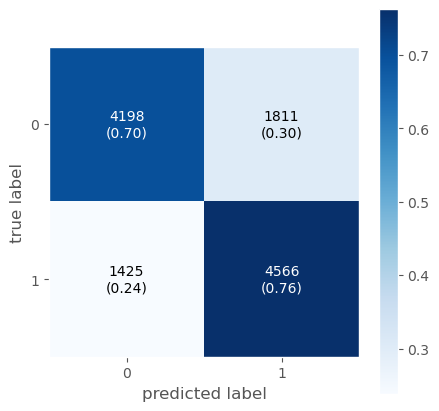

time: 172 ms (started: 2024-02-03 09:52:59 +01:00)


In [81]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

#### Courbe ROC
- La courbe ROC représente la part de vrais positifs en fonction du nombre de faux positifs, pour différentes valeurs du seuil de décision.

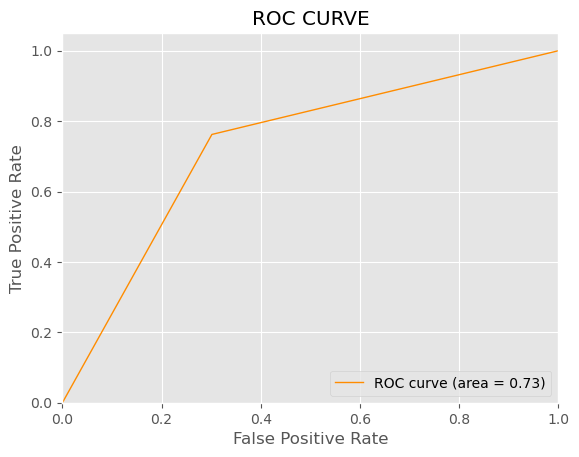

time: 156 ms (started: 2024-02-03 09:53:00 +01:00)


In [82]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modèle avec LSTM

###  Separation des features et des labels

In [83]:
X=data.text
y=data.label

time: 0 ns (started: 2024-02-03 09:54:07 +01:00)


### Encodage séquentiel des tokens
- conversion du texte en séquences numériques
- chaque tweet correspond à une séquence de 500 nombres
    - les tweet plus courts sont 'paddés' avec des 0 au début de la séquence
    - les tweet plus longs sont tronqués pour avoir seulement 500 nombres

In [84]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

time: 531 ms (started: 2024-02-03 09:54:07 +01:00)


J'ai donc 40 000 tweets, chaque tweet étant associé à 500 features.

Par exemple, pour la première ligne (premier tweet), la cinquième feature contient le nombre associé au mot correspondant, en cinquième position de la séquence (0 si le tweet a un nombre de tokens inférieur 495); et la dernière ligne contient le nombre associé au dernier mot du tweet.

In [85]:
sequences_matrix.shape

(40000, 500)

time: 0 ns (started: 2024-02-03 09:54:07 +01:00)


### Séparation des données entraînement-test (70-30)

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

time: 31 ms (started: 2024-02-03 09:54:07 +01:00)


### Compilation du modèle

In [87]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

time: 0 ns (started: 2024-02-03 09:54:07 +01:00)


- Etape 1 : l'input du modèle est constitué de 500 éléments, correspondant aux tokens encodés de façon séquentielle pour chaque tweet.

- Etape 2 : l'embedding permet de représenter les mots de manière à ce que les mots ayant des significations similaires soient proches les uns des autres dans cet espace vectoriel à 50 dimensions. J'ai ici précisé que je représente 2000 mots dans un espace de dimension 50. Ainsi, pour chaque tweet, chaque élément de la séquence associée au tweet sera représenté comme un vecteur de dimension 50.

- Etape 3 : les couches LSTM (long short term memory) traitent chaque mot en prenant en compte les informations des mots précédents dans la séquence. Ces couches permettent ainsi de ne pas traiter les mots seulement de façon isolée, mais de prendre également en compte le contexte fourni par les mots précédents.

- Etape 4 : les couches denses (fully-connected) permettent de combiner et transformer les caractéristiques de bas niveau extraites par les couches précédentes (comme les séquences de mots) en caractéristiques de plus haut niveau, utiles pour la classification. Elles permettent au modèle d'apprendre et de généraliser à partir des données d'entraînement pour faire des prédictions sur de nouvelles données non vues.

- Etape 5 : la couche d'activation permet d'introduire une non-linéarité, afin de déterminer quels neurones sont activés ou non. 

- Step 6 : la couche de dropout permet d'enlever certains neurones lors de l'apprentissage, afin de limiter les risques d'overfitting en empêchant les neurones de trop se "co-adapter". En d'autres terme, cela encourage le modèle à ne pas se reposer sur un set de neurones réduits pour effectuer la prédiction, et à apprendre des features plus robustes, qui se retrouvent avec différents sous-sets de neurones dans les couches précédentes.

### Instanciation du modèle

- Dans un premier temps, j'instancie le modèle.
- Je définis ma métrique, qui est l'aire sous la courbe ROC (Receiver Operating Characteristic Curve).
- J'utilise la fonction de perte "binary_crossentropy", adaptée pour une classification binaire.
- J'utilise l'optimiseur "RMSprop", qui définit comment la mise à jour des poids doit s'effectuer.

In [88]:
from tensorflow.keras.metrics import AUC

### Configure AUC metric for binary classification
auc_roc = AUC(curve='ROC')

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=[auc_roc])  

time: 250 ms (started: 2024-02-03 09:54:07 +01:00)


### Entraînement du modèle
- 90% des données sont utilisées pour l'entraînement, et 10% pour la validation.
- A chaque itération (processing complet du modèle), le modèle prend en compte un lot de 80 tweets et met à jour ses paramètres.
- Il y a 6 epochs, ce qui signifie que le modèle parcourt 6 fois l'ensemble des données intégralement.

In [89]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1) # here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
315/315 [==============================] - 113s 353ms/step - loss: 0.6157 - auc_6: 0.7162 - val_loss: 0.5397 - val_auc_6: 0.8117
Epoch 2/6
315/315 [==============================] - 112s 356ms/step - loss: 0.5155 - auc_6: 0.8245 - val_loss: 0.5198 - val_auc_6: 0.8197
Epoch 3/6
315/315 [==============================] - 116s 369ms/step - loss: 0.4982 - auc_6: 0.8384 - val_loss: 0.5168 - val_auc_6: 0.8216
Epoch 4/6
315/315 [==============================] - 117s 372ms/step - loss: 0.4890 - auc_6: 0.8454 - val_loss: 0.5160 - val_auc_6: 0.8246
Epoch 5/6
315/315 [==============================] - 117s 373ms/step - loss: 0.4785 - auc_6: 0.8522 - val_loss: 0.5263 - val_auc_6: 0.8211
Epoch 6/6
315/315 [==============================] - 117s 373ms/step - loss: 0.4678 - auc_6: 0.8595 - val_loss: 0.5248 - val_auc_6: 0.8171
Training finished !!
time: 11min 33s (started: 2024-02-03 09:54:07 +01:00)


### Test du modèle

In [90]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

375/375 [==============================] - 16s 41ms/step - loss: 0.5178 - auc_6: 0.8224
time: 16.1 s (started: 2024-02-03 10:05:41 +01:00)


In [91]:
print('Test set\n  Area under the ROC Curve: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Area under the ROC Curve: 0.82
time: 0 ns (started: 2024-02-03 10:05:57 +01:00)


### Comparaison labels/prédictions

Pour la comparaison, je fixe un seuil de prédiction à 0.5 : les tweets avec une probabilité supérieure à 0.5 sont prédits comme positifs, et les autres négatifs.

In [92]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 15s 40ms/step
time: 15.7 s (started: 2024-02-03 10:05:57 +01:00)


#### Matrice de confusion

Voici la matrice de confusion :



confusion matrix


[[4405 1604]
 [1464 4527]]




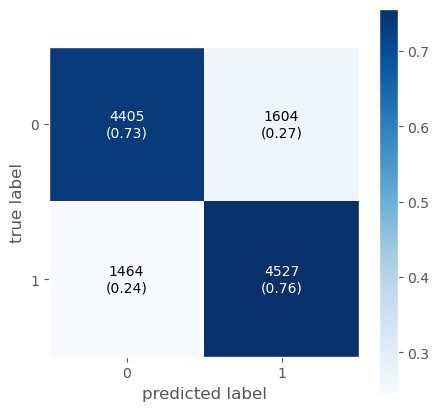

time: 157 ms (started: 2024-02-03 10:06:12 +01:00)


In [93]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(5, 5),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

#### Courbe ROC
- La courbe ROC représente la part de vrais positifs en fonction du nombre de faux positifs, pour différentes valeurs du seuil de décision.

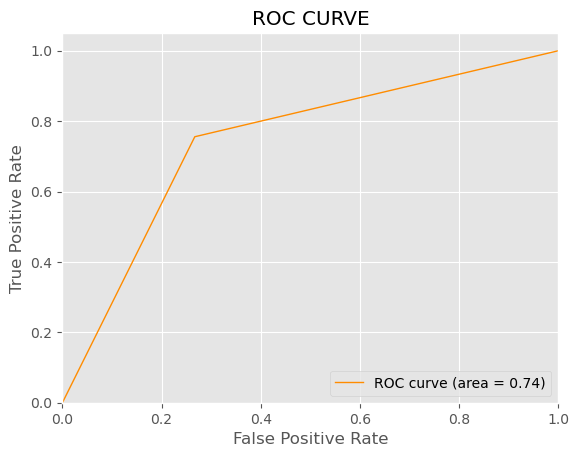

time: 156 ms (started: 2024-02-03 10:06:13 +01:00)


In [94]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modèle avec Transformers (BERT)

### Imports et Variables Initiales

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available! Device: {torch.cuda.get_device_name(0)}")
    # Set PyTorch to use the GPU
    torch.cuda.set_device(0)
else:
    print("CUDA is not available. Check your installation.")

CUDA is available! Device: Tesla V100-SXM2-16GB


### Lecture des données

In [13]:
#df = pd.read_csv('data_raw/reviews.csv')
df = pd.read_csv("data_raw/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
df.columns = ["label", "time", "date", "query", "username", "text"]
df=df[['text','label']]
df.shape

(1599999, 2)

### Séparation des tweets positifs et négatifs (reproduction des traitements dans la première partie du notebook)

In [14]:
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]

print("number of positives", df_pos.shape[0])
print("number of negatives", df_neg.shape[0])

number of positives 800000
number of negatives 799999


### Garder seulement 25% des données, afin de pouvoir faire tourner le programme rapidement dans un premier temps

In [15]:
df_pos = df_pos.iloc[:int(20000)]
df_neg = df_neg.iloc[:int(20000)]

### Fusion des deux tableaux pour faire un tableau avec 20 000 tweets positifs et 20 000 tweets négatifs

In [16]:
df = pd.concat([df_pos, df_neg])

In [17]:
# Let's have a look at the data
df.head()

,text,label
799999,I LOVE @Health4UandPets u guys r the best!!,4
800000,im meeting up with one of my besties tonight! ...,4
800001,"@DaRealSunisaKim Thanks for the Twitter add, S...",4
800002,Being sick can be really cheap when it hurts t...,4
800003,@LovesBrooklyn2 he has that effect on everyone,4


In [19]:
df['label'].value_counts()

4    20000
0    20000
Name: label, dtype: int64

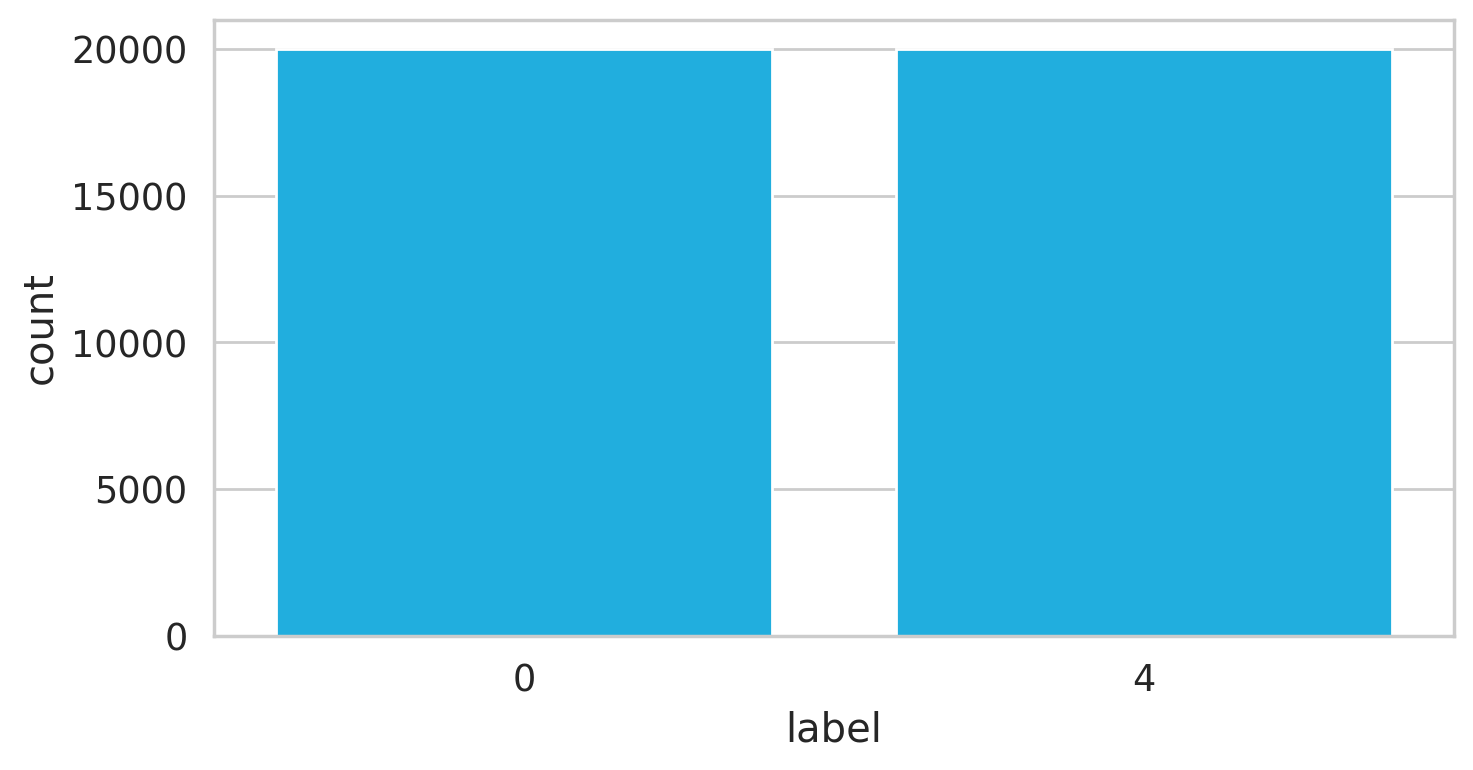

In [20]:
# Let's have a look at the class balance.
plt.figure(figsize=(8, 4))
#sns.countplot(x='score', data=df)
sns.countplot(x='label', data=df)
plt.show()

In [21]:
# Function to convert score to sentiment
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset
# df['sentiment'] = df.score.apply(to_sentiment)
df['sentiment'] = df['label'].replace(4, 1)

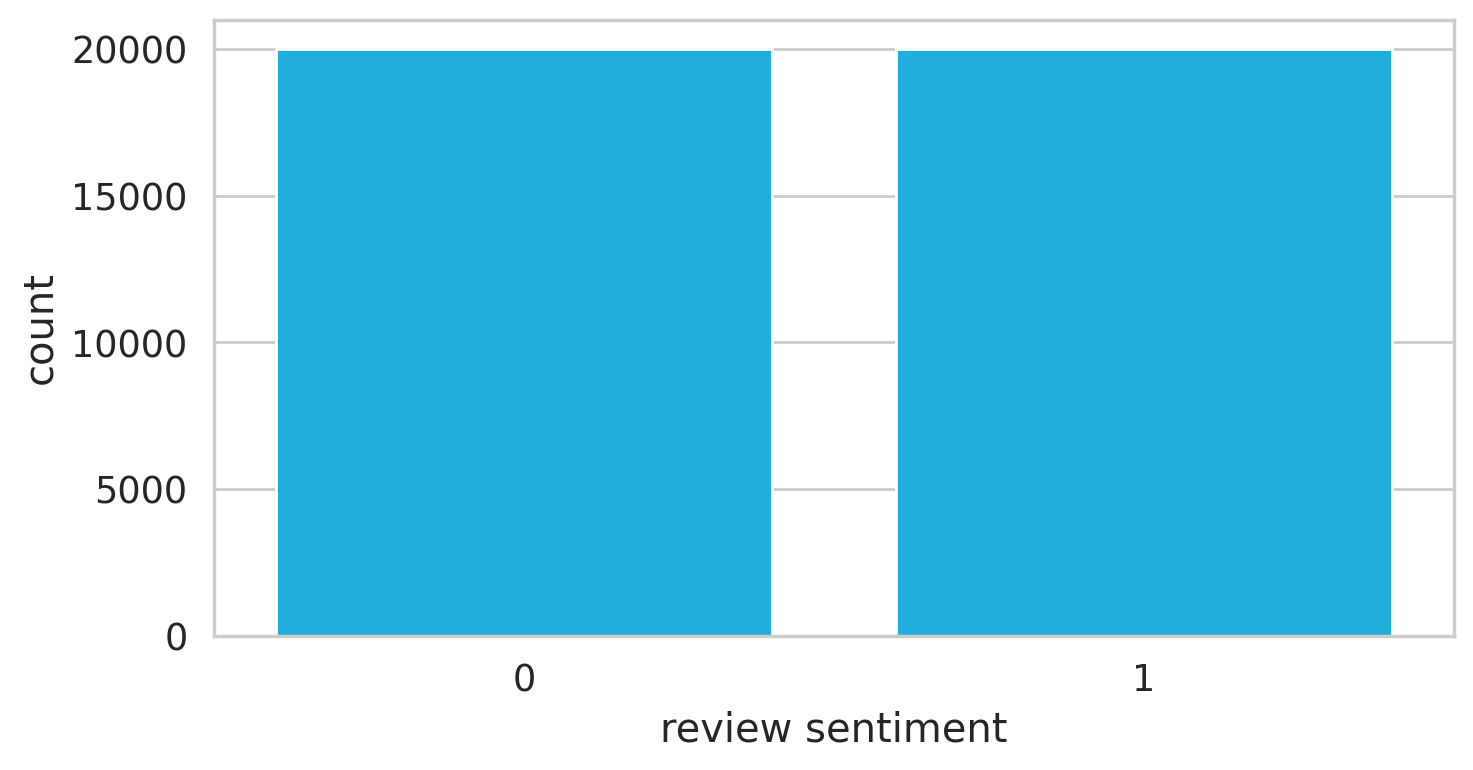

In [22]:
# Plot the distribution
class_names = ['negative', 'positive']

plt.figure(figsize=(8, 4))
sns.countplot(x='sentiment', data=df)
plt.xlabel('tweet sentiment')
plt.show()

### Preprocessing des données

Les modèles BERT nécessitent une tokenization plus spécifique, par rapport aux modèles classiques.

Il est nécessaire :

- d'ajouter des tokens spéciaux (artificiels) afin de séparer les phrases
- d'effectuer un padding spécifique (consistant à uniformiser la taille de tous les tweets, avec des tokens qui signalent l'absence de mot)
- ce padding se traduit en la création d'un vecteur d'attention, contenant des 0 ou des 1 pour signaler la présence ou l'absence de mot sur l'ensemble de la séquence

Parmi les modèles BERT, j'ai choisi la version 'cased', qui est intéressante car elle prend en compte les majuscules sur l'ensemble d'un mot, en considérant par exemple ue GREAT et great ne sont pas la même chose, et que BAD est plus extrême que bad. C'est particulièrement intéressant pour un dataset constitué de tweets, où il est courant d'utiliser les majuscules à des fins expressives.

En plus de cela, le tokenizer de BERT effectue dejà une forme d'encodage au niveau des tokens, en associant directement une valeur numérique à chaque mot.

In [23]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT fonctionne avec des séquences de taille fixe (ex: 50 tokens).

Afin de choisir cette taille, il est utile de regarder les tweets pour déterminer la longueure maximale.

In [25]:
# Store length of each review
token_lens = []

# Iterate through the content slide
#for txt in df.content:
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

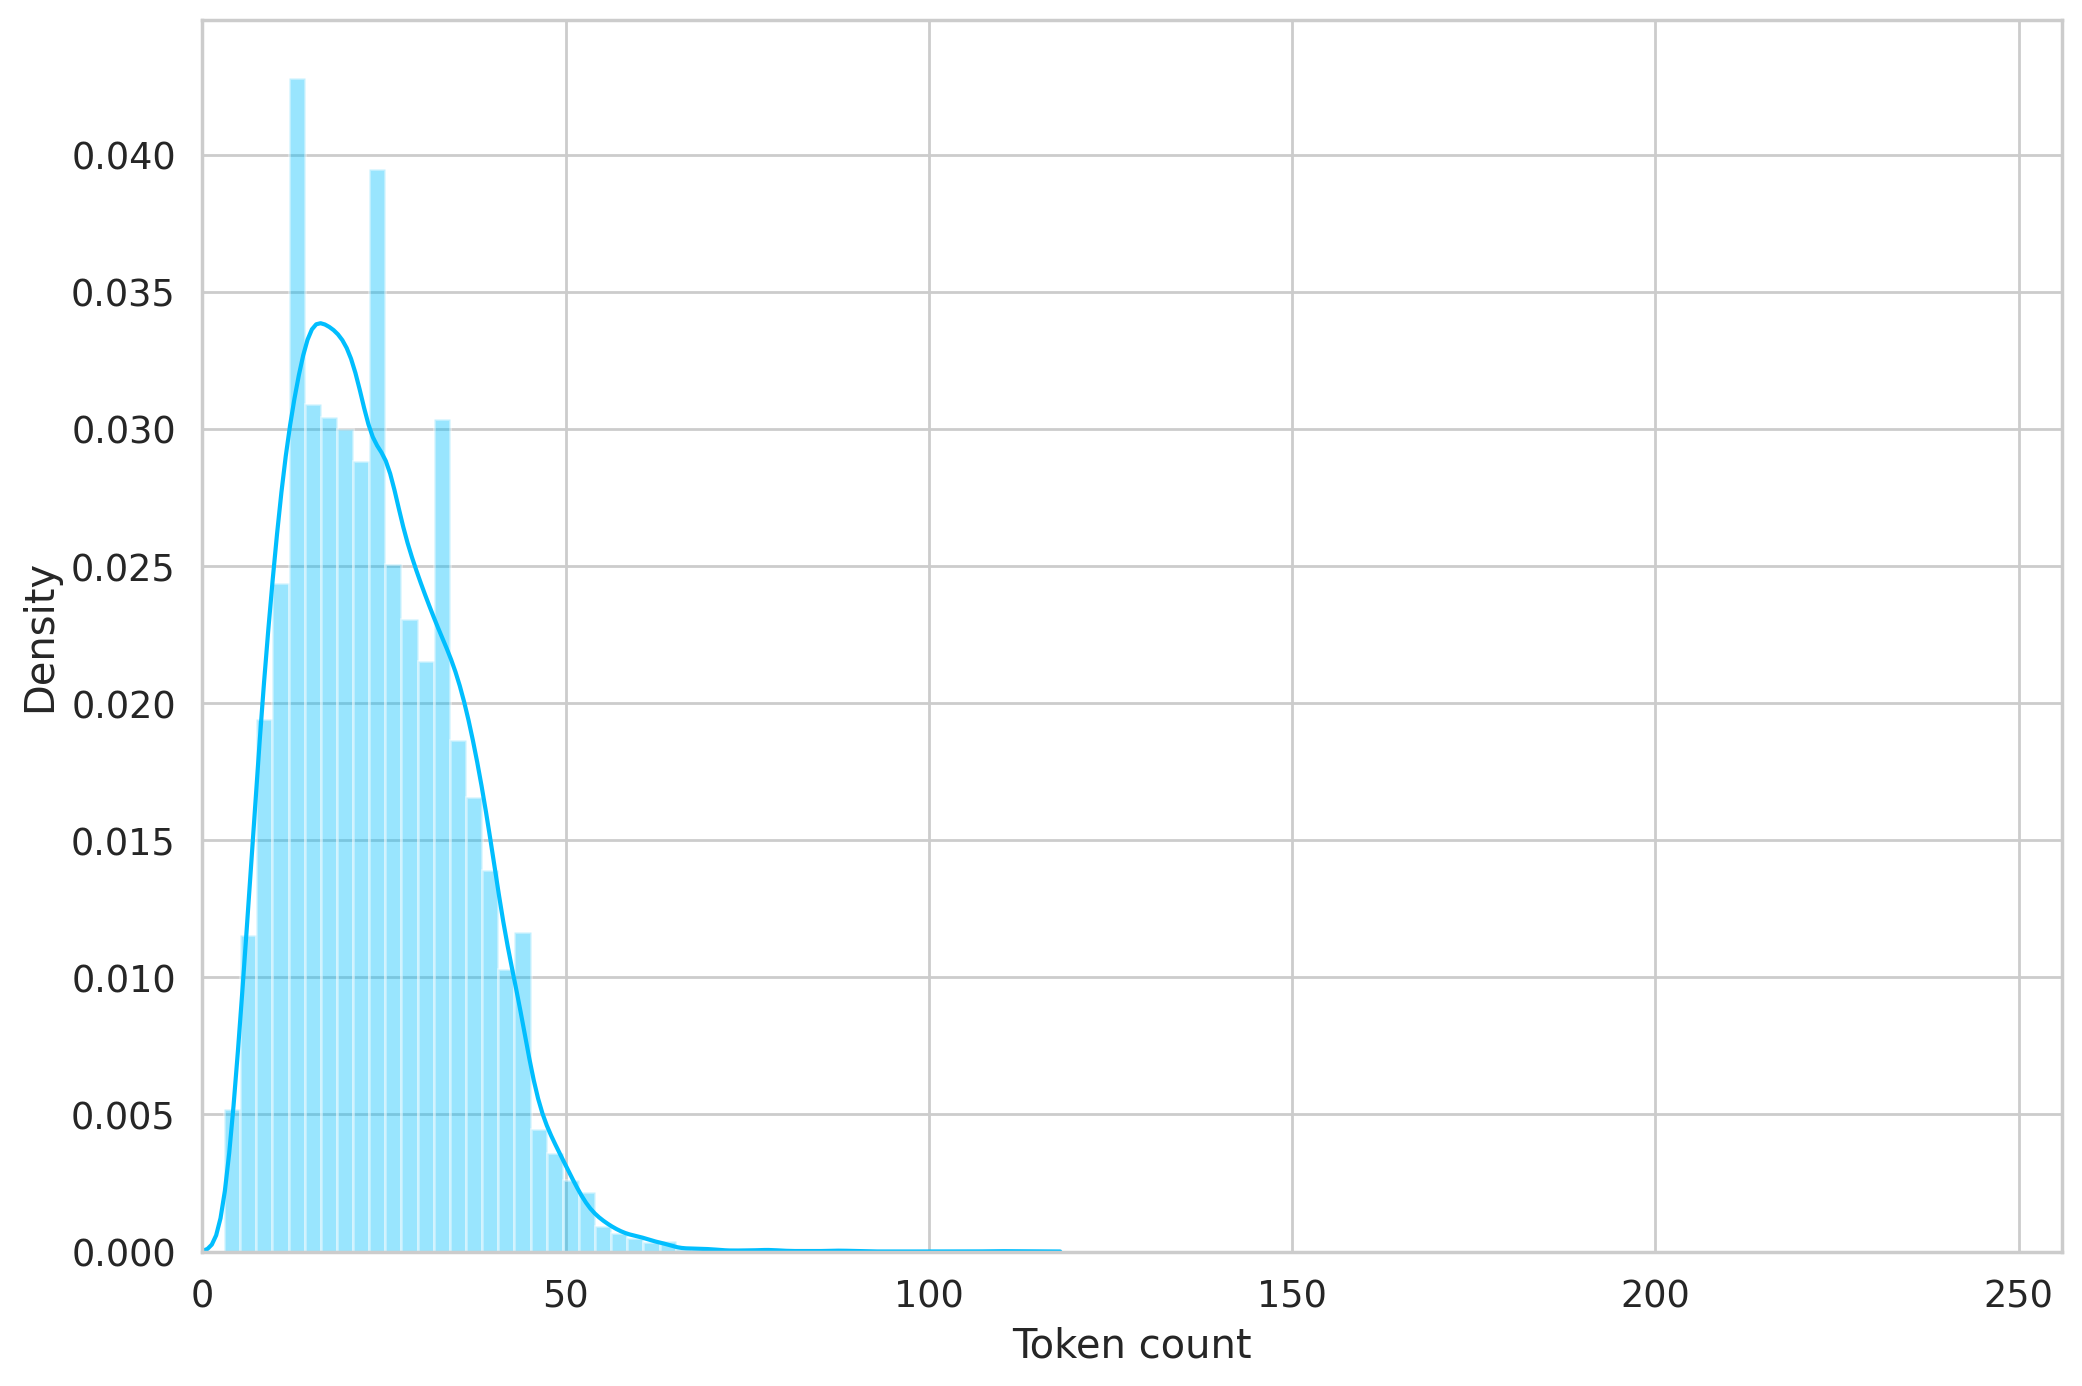

In [26]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

La plupart des tweets comprennent moins de 70 mots.

J'ai choisi une longueur de séquence de 100 mots afin d'être un peu plus large.

In [27]:
MAX_LEN = 100

### Preparing Torch Dataset

Pour que PyTorch puisse traiter les données, il est nécessaire de construire une classe 'data generator' robuste, comprenant :
- les tweets
- les input_id (le code de chaque token)
- les masques d'attention (0 ou 1 pour indiquer la présence d'un mot ou non sur la séquence de taille fixe)
- les labels (positifs ou négatifs)

In [28]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Je créé un set d'entraînement avec 80% des données, un set de validation avec 10%, et un set de test avec 10% des données :

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(32000, 3) (4000, 3) (4000, 3)


Je créé également un 'data loader' afin de traiter les données par 'batches', avec seulement un échantillon des données à la fois.

In [30]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [31]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


### Model Loading

J'utilise le modèle BERT pré-entrtaîné, et je construis mon classifieur de tweets en sur-couche :

In [33]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [34]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # # Forward propagaion class
    # def forward(self, input_ids, attention_mask):
    #     _, pooled_output = self.bert(
    #       input_ids=input_ids,
    #       attention_mask=attention_mask
    #     )
    #     #  Add a dropout layer
    #     output = self.drop(pooled_output)
    #     return self.out(output)

    # Debug suggestion by a kaggle user in the comments
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output # Accessing the pooled output
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

J'utilise une couche de dropout afin d'effectuer une régularisation. Cette couche va permettre de diminuer la complexité du modèle, en retirant un certain nombre de neurones au hasard.

J'utilise également une couche fully-connected afin de synthétiser les observations de tous les neurones dans une prise de décision.

Après avoir créé une instance du modèle, je la bascule sur le GPU afin d'optimiser les traitements.

In [35]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Caractéristiques du modèle

In [36]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Entraînement

J'utilise l'optimisateur AdamW, fourni par Hugging Face.

Cet optimiseur permet de corriger l'evanescence des poids.

J'utilise également un scheduler linéaire sans warmup.

In [37]:
# Number of iterations
EPOCHS = 6

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [38]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Voici la fonction permettant d'évaluer la performance du modèle :

In [39]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Voici la boucle permettant d'entraîner le modèle, et de conserver les meilleurs paramètres.

In [40]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/6
----------
Train loss 0.4452846932299435 accuracy 0.79734375
Val   loss 0.39466872322559354 accuracy 0.81675

Epoch 2/6
----------
Train loss 0.28188248273963107 accuracy 0.891375
Val   loss 0.4345270946621895 accuracy 0.8195

Epoch 3/6
----------
Train loss 0.18415440830198349 accuracy 0.94375
Val   loss 0.6449556779041886 accuracy 0.8180000000000001

Epoch 4/6
----------
Train loss 0.12051014012438827 accuracy 0.9687187500000001
Val   loss 0.8771526861563325 accuracy 0.82375

Epoch 5/6
----------
Train loss 0.08372068626366672 accuracy 0.979875
Val   loss 1.0111794984047302 accuracy 0.82625

Epoch 6/6
----------
Train loss 0.05312242275366589 accuracy 0.9883125
Val   loss 1.081994949642569 accuracy 0.82375

CPU times: user 15min 34s, sys: 3min 24s, total: 18min 59s
Wall time: 18min 58s


Le modèle tourne en 20 minutes sur google colab, en utilisant un GPU V100 (7 minutes pour un GPU A100).

### Model Evaluation

In [42]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8260000000000001

Voici une fonction permettant d'évaluer les predictions.

In [43]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [44]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [45]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      2014
    positive       0.82      0.83      0.83      1986

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



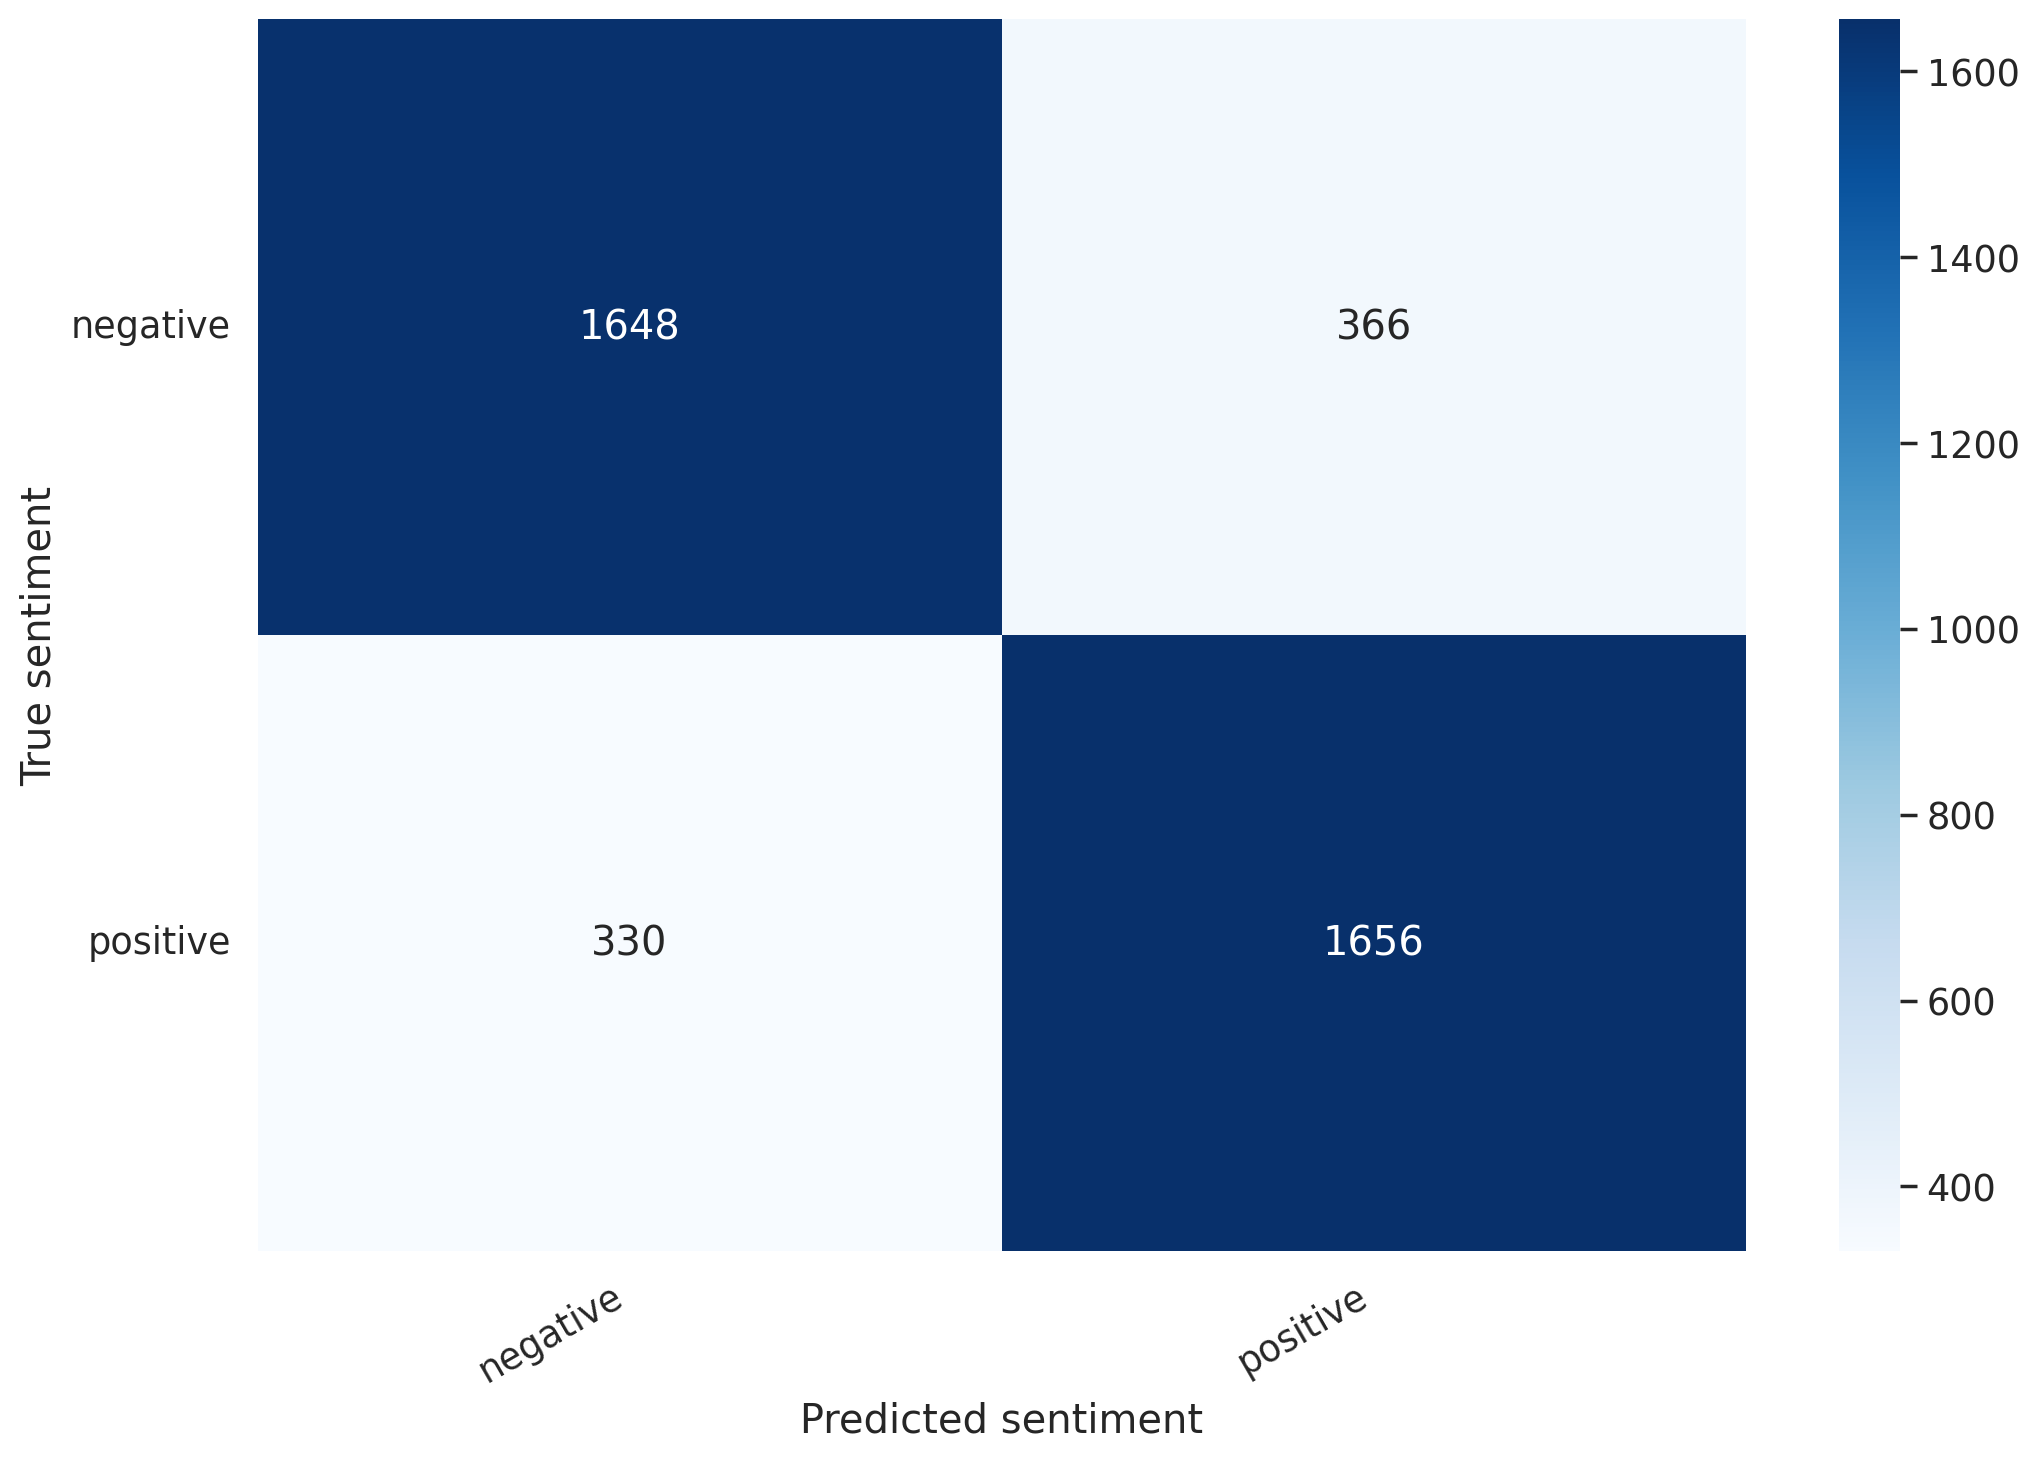

In [46]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Pour le moment, le modèle a pratiquement le même nombre de vrais négatifs et positifs (environ 1500 tweets de chaque), et le même nombre de faux positifs et négatifs (environ 350 tweets de chaque).

## Synthèse des résultats

In [5]:
data = {
    "CountVectorizer": ["5min", "1s",0.74],
    "Tf-idf": ["5min","1s",0.77],
    "NN + Embedding simple": ["20min","1min 18s",0.80],
    "NN + LSTM": ["20min","11min 33s",0.82],
    "NN + Transformers": ["7h","20min (GPU V100)",0.83]
}

df = pd.DataFrame(data, index=["Temps d'implémentation","Temps d'entraînement","Aire sous la courbe ROC"])
df.T

,Temps d'implémentation,Temps d'entraînement,Aire sous la courbe ROC
CountVectorizer,5min,1s,0.74
Tf-idf,5min,1s,0.77
NN + Embedding simple,20min,1min 18s,0.8
NN + LSTM,20min,11min 33s,0.82
NN + Transformers,7h,20min (GPU V100),0.83
